In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

In [30]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten
from keras.optimizers import Adam, SGD
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [31]:
tweets_df = pd.read_csv('/content/train.csv')


In [32]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


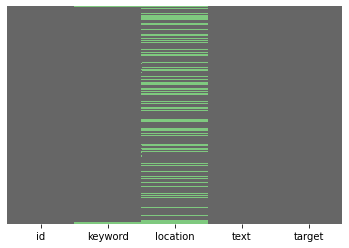

In [33]:
sns.heatmap(tweets_df.isnull(),cmap='Accent_r',yticklabels=False,cbar=False)

In [34]:
tweets_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [35]:
tweets_df[tweets_df.keyword.notnull()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [36]:
tweets_df.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [37]:
tweets_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [38]:
tweets_df['keyword_p'] = np.where(tweets_df['keyword'].isnull(),0,1)

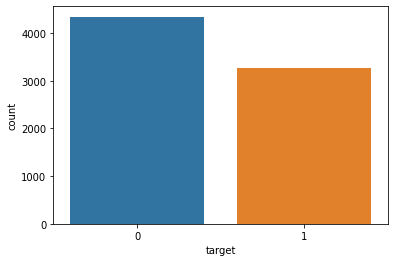

In [39]:
sns.countplot(tweets_df['target'])

In [40]:
tweets_df.keyword.isnull().sum()

61

In [41]:
#Find the number of characters, words in every tweet
tweets_df['length'] = tweets_df['text'].apply(len)


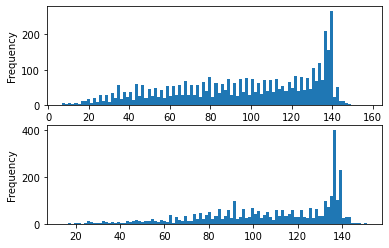

In [42]:
plt.subplot(211)
tweets_df[tweets_df['target']==0]['length'].plot(bins=100,kind='hist');
plt.subplot(212)
tweets_df[tweets_df['target']==1]['length'].plot(bins=100,kind='hist');

In [43]:
tweets_df.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [44]:
tweets_df[tweets_df['length']==7][['text','target']]

,text,target
1882,Crushed,0
4890,Bad day,0
5115,Err:509,0


In [45]:
sentences = tweets_df['text'].tolist()

In [46]:
len(sentences)

7613

In [47]:
sentences_as_one_string = " ".join(sentences)

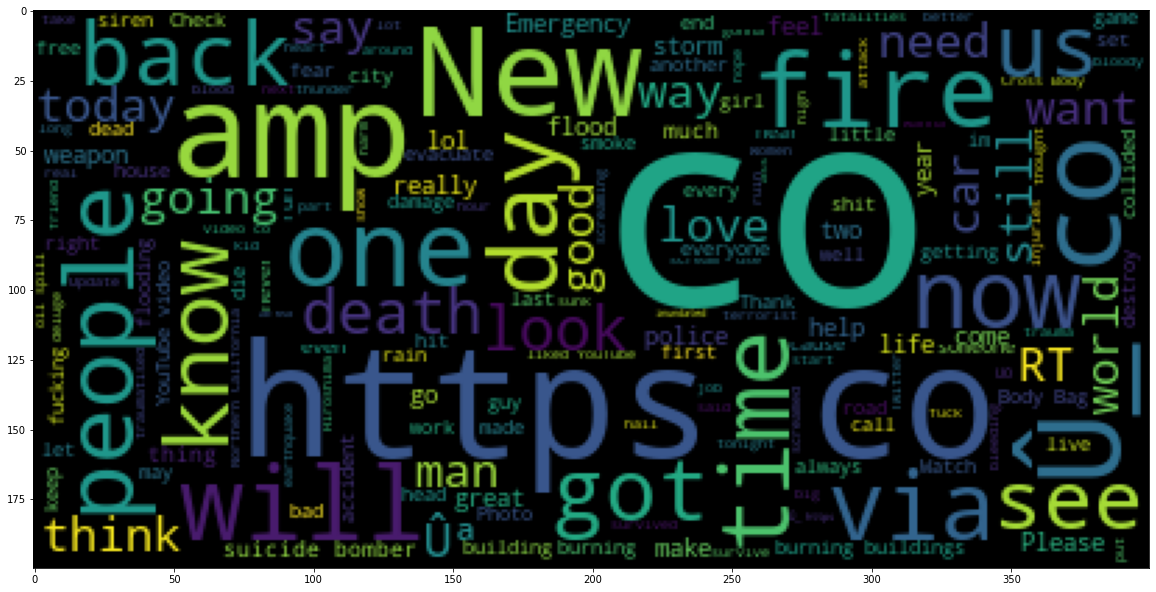

In [48]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(sentences_as_one_string))

In [49]:
#Perform datacleaning - Remove punctuation from text
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [50]:
#Analyze stop words
import nltk #natural language tool kit
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
from nltk.corpus import stopwords
len(stopwords.words('english'))

179

In [52]:
test_df = pd.read_csv('/content/test.csv')
tweets_df['keyword'] = tweets_df['keyword'].fillna('')
test_df['keyword'] = test_df['keyword'].fillna('')

#add keyword to tweets
tweets_df['text'] = tweets_df['text'] + ' ' + tweets_df['keyword']
test_df['text'] = test_df['text'] + ' ' + test_df['keyword']

total_df = tweets_df.append(test_df)

In [53]:
def message_cleaning(message): #Remove url, punctunations, stop words
  url = re.compile(r'https?://\S+|www\.\S+')
  text_without_url = url.sub(r'',message)
  text_punc_removed = [char for char in text_without_url if char not in string.punctuation]
  text_punc_removed_join = "".join(text_punc_removed)
  text_punc_stopwords_removed = [word for word in text_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
  text_punc_stopwords_removed = " ".join(text_punc_stopwords_removed)
  return text_punc_stopwords_removed.lower()

In [54]:
tweets_df['CleanedText'] = tweets_df['text'].apply(message_cleaning)

In [55]:
tweets_df.head()

,id,keyword,location,text,target,keyword_p,length,CleanedText
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,69,deeds reason earthquake may allah forgive us
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,0,38,forest fire near la ronge sask canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,0,133,residents asked shelter place notified officer...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,0,65,13000 people receive wildfires evacuation orde...
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,88,got sent photo ruby alaska smoke wildfires pou...


In [56]:
disaster = tweets_df[tweets_df['target']==1]['CleanedText'].tolist()
nondisaster = tweets_df[tweets_df['target']==0]['CleanedText'].tolist()


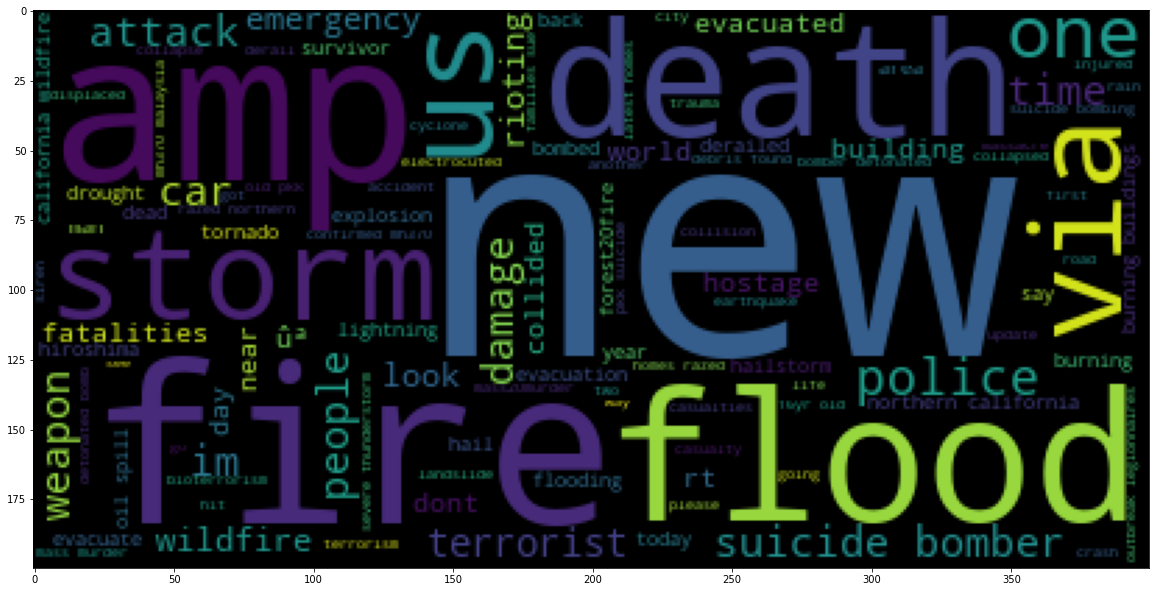

In [57]:
disaster_text = " ".join(disaster)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(disaster_text))

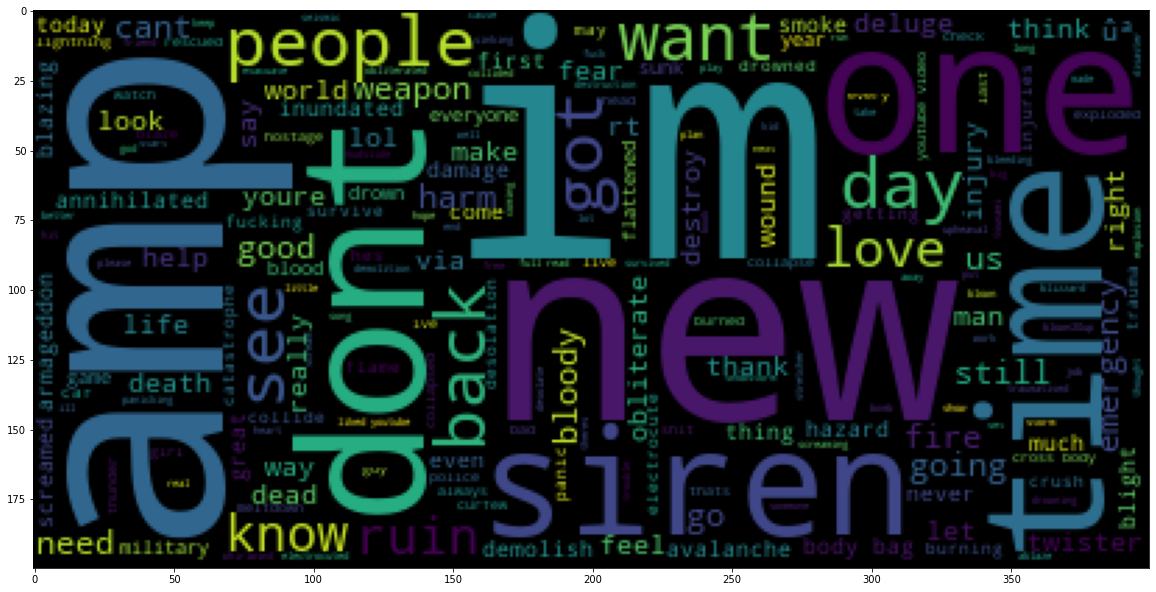

In [58]:
non_disaster_text = " ".join(nondisaster)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(non_disaster_text))

In [59]:

test_df['CleanedText'] =  test_df['text'].apply(message_cleaning)




In [61]:
test_df.head()

,id,keyword,location,text,CleanedText
0,0,,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan


In [62]:
X_train = tweets_df['CleanedText'].values.reshape(len(tweets_df),)
y_train =  tweets_df['target'].values
X_test = test_df['CleanedText'].values.reshape(len(test_df),)

In [63]:
total_tweets = np.concatenate((X_train, X_test))
print('Total tweets : ', len(total_tweets))

Total tweets :  10876


In [64]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_tweets)


vocab_size = len(tokenizer.word_index) + 1
print('Size of Vocabulary : ', vocab_size)

Size of Vocabulary :  22710


In [65]:
# Maximum length for padding sequence
maxlen = max(len(x.split()) for x in total_tweets)
print('Maximum length of tweet : ', maxlen)

Maximum length of tweet :  26


In [66]:
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

print('Text before tokenized')
print(X_train[0])
print('\nText after tokenized')
print(X_train_token[0])

Text before tokenized
deeds reason earthquake may allah forgive us

Text after tokenized
[5686, 740, 72, 88, 1821, 3613, 15]


In [67]:
X_train_pad = pad_sequences(X_train_token, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_token, maxlen=maxlen, padding='post')

print('Tokenized text before padding')
print(X_train_token[0])
print('\nTokenized text after padding')
print(X_train_pad[0])

Tokenized text before padding
[5686, 740, 72, 88, 1821, 3613, 15]

Tokenized text after padding
[5686  740   72   88 1821 3613   15    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [68]:
hidden_units = 128
embed_units = 100

model = Sequential()
model.add(Embedding(vocab_size, embed_units, input_length = maxlen))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dropout(0.2))
#model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 100)           2271000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,571,545
Trainable params: 2,571,545
Non-trainable params: 0
______________________________________________

In [69]:
learning_rate = 0.0001

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [70]:
batch_size = 512
num_itr = 10

model_history = model.fit(X_train_pad, y_train, 
                          batch_size=batch_size, 
                          epochs=num_itr, 
                          validation_split=0.2)

Epoch 1/10
12/12 [==============================] - 7s 589ms/step - loss: 0.6785 - accuracy: 0.5713 - val_loss: 0.6803 - val_accuracy: 0.5345
Epoch 2/10
12/12 [==============================] - 6s 526ms/step - loss: 0.5921 - accuracy: 0.7026 - val_loss: 0.5649 - val_accuracy: 0.7249
Epoch 3/10
12/12 [==============================] - 6s 519ms/step - loss: 0.3428 - accuracy: 0.8603 - val_loss: 0.4916 - val_accuracy: 0.7899
Epoch 4/10
12/12 [==============================] - 6s 525ms/step - loss: 0.2015 - accuracy: 0.9228 - val_loss: 0.5882 - val_accuracy: 0.7269
Epoch 5/10
12/12 [==============================] - 6s 529ms/step - loss: 0.1178 - accuracy: 0.9565 - val_loss: 0.6737 - val_accuracy: 0.7459
Epoch 6/10
12/12 [==============================] - 6s 522ms/step - loss: 0.0789 - accuracy: 0.9701 - val_loss: 0.8419 - val_accuracy: 0.7387
Epoch 7/10
12/12 [==============================] - 6s 526ms/step - loss: 0.0547 - accuracy: 0.9795 - val_loss: 0.9546 - val_accuracy: 0.7282
Epoch 

In [71]:
pred = model.predict(X_test_pad)

In [72]:
sub = pd.read_csv('/content/sample_submission.csv')
sub["target"] = pred
sub["target"] = sub["target"].apply(lambda x : 0 if x<=.5 else 1)

In [73]:
sub.to_csv("pred1_lstm.csv", index=False)

In [74]:
total_df['CleanedText'] = total_df['text'].apply(message_cleaning)


In [76]:
tweets = total_df['CleanedText']

In [77]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

tokenizer = Tokenizer()    
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = tweets_df['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(tweets_df)]
labels = labels
nlp_test = data[len(tweets_df):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 22709 unique tokens.
Shape of data tensor: (10876, 26)
Shape of label tensor: (7613,)


In [79]:
#Use GloVe

from tqdm import tqdm
embeddings_index = {}
with open('/content/glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:24, 16307.48it/s]

Found 400000 word vectors in the GloVe library


In [94]:
EMBEDDING_DIM = 200   #defined by size of GloVe word vector dimensions
#for k in sorted(embeddings_index)[:1]:
    #print (k,embeddings_index[k])

len(embeddings_index['hello'])
len(embeddings_index)

400000

In [95]:
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 22709/22709 [00:00<00:00, 439822.73it/s]


In [96]:
#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  



In [97]:
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
   
    nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
       
     
    #add meta data    
    x = nlp_out
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=nlp_input, outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [98]:
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nlp_input (InputLayer)       [(None, 26)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 26, 200)           4542000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 26, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 4,783,001
Trainable params: 241,001
Non-trainable params: 4,542,000
______________________________________

In [100]:
history1 = lstm.fit(nlp_train, labels, validation_split = .2,
                       epochs = 5, batch_size = 21, verbose = 1)

Epoch 1/5
290/290 [==============================] - 31s 107ms/step - loss: 0.3796 - accuracy: 0.8360 - val_loss: 0.4041 - val_accuracy: 0.8201
Epoch 2/5
290/290 [==============================] - 31s 106ms/step - loss: 0.3710 - accuracy: 0.8415 - val_loss: 0.4243 - val_accuracy: 0.8234
Epoch 3/5
290/290 [==============================] - 31s 107ms/step - loss: 0.3558 - accuracy: 0.8491 - val_loss: 0.4269 - val_accuracy: 0.8142
Epoch 4/5
290/290 [==============================] - 30s 105ms/step - loss: 0.3515 - accuracy: 0.8507 - val_loss: 0.4205 - val_accuracy: 0.8109
Epoch 5/5
290/290 [==============================] - 30s 105ms/step - loss: 0.3403 - accuracy: 0.8555 - val_loss: 0.4271 - val_accuracy: 0.8017


In [101]:
pred_2 = lstm.predict(nlp_test)


In [102]:
sub = pd.read_csv('/content/sample_submission.csv')
sub["target"] = pred_2
sub["target"] = sub["target"].apply(lambda x : 0 if x<=.5 else 1)

sub.to_csv("pred2_lstm.csv", index=False)